In [335]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [336]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [337]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [338]:
root='./data'
download=True
batch_size=int(2**11)
shuffle=False
include_last_if_uneven=True
binarise_thesh=0.5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=True,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thesh=binarise_thesh,
)
test_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=False,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thesh=binarise_thesh,
)

In [339]:
for batch_id, datum in enumerate(tqdm.tqdm(test_MNIST_loader)):
    if batch_id == 0:
        print(batch_id)
        print(torch.max(datum.input))
        print(torch.min(datum.input))
        print(datum.target)

 40%|████      | 2/5 [00:00<00:00, 15.94it/s]

0
tensor(1, dtype=torch.int32)
tensor(-1, dtype=torch.int32)
tensor([[-1, -1, -1,  ...,  1, -1, -1],
        [-1, -1,  1,  ..., -1, -1, -1],
        [-1,  1, -1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1]], dtype=torch.int32)


100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


In [340]:
len(test_MNIST_loader), len(train_MNIST_loader)

(5, 30)

In [341]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [342]:
#backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)

In [343]:
INPUT_DIM = bnn.data.MNISTDataLoader.input_size
OUTPUT_DIM = bnn.data.MNISTDataLoader.output_size

In [344]:
dims = [INPUT_DIM, 1024, 512, 256, 128, OUTPUT_DIM]
TBNN = bnn.network.TernBinNetwork(
    dims,
    forward_func=forward_func,
    backward_func=backward_func,
)
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [345]:
TBNN.to(device)
train_MNIST_loader.to(device)
test_MNIST_loader.to(device)

In [346]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [347]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.000001)

In [348]:
losses = []

In [349]:
train_epochs = 5000
num_logs = 200
epoch_log_rate = train_epochs // num_logs

In [350]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_unproj = TBNN.forward_no_proj(batch.input)
    output_argmax = torch.argmax(output_unproj, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 17.21it/s]

accuracy: 0.09629999846220016


In [351]:
zero_loss_count = 0
zero_loss_count_for_early_stop = 10
for epoch in tqdm.trange(train_epochs):
    epoch_loss = 0
    prop_flipped = 0
    for batch_id, batch in enumerate(train_MNIST_loader):
        # forward pass and loss
        output = TBNN.forward(batch.input)
        loss = loss_func.forward(output=output, target=batch.target)

        # backward pass
        grad = loss_func.backward(output=output, target=batch.target)
        out_grad = TBNN.backward(grad)

        # optimizer step
        prop_flipped += BernOpt.step()

        # sum loss
        epoch_loss += loss

        break

    # save loss
    losses.append(epoch_loss.cpu())

    if epoch_loss == 0:
        zero_loss_count += 1
    else:
        zero_loss_count = 0

    early_exit = zero_loss_count >= zero_loss_count_for_early_stop

    if early_exit or (epoch % epoch_log_rate) == 0:
        mean_prop_flipped = prop_flipped / (1 + batch_id)
        print(f'epoch: {epoch}\tloss: {loss}\tmean_prop_flipped: {mean_prop_flipped}')

    if early_exit:
        break

  0%|          | 1/5000 [00:00<35:58,  2.32it/s]

epoch: 0	loss: 10.5205078125	mean_prop_flipped: 8.041688124649227e-05


  1%|          | 26/5000 [00:11<37:41,  2.20it/s]

epoch: 25	loss: 4.6884765625	mean_prop_flipped: 1.3402813237917144e-05


  1%|          | 51/5000 [00:23<35:58,  2.29it/s]

epoch: 50	loss: 3.912109375	mean_prop_flipped: 1.27326720757992e-05


  2%|▏         | 76/5000 [00:34<37:02,  2.22it/s]

epoch: 75	loss: 3.677734375	mean_prop_flipped: 1.4072953490540385e-05


  2%|▏         | 101/5000 [00:47<38:23,  2.13it/s]

epoch: 100	loss: 3.5927734375	mean_prop_flipped: 1.4743094652658328e-05


  3%|▎         | 126/5000 [00:58<36:32,  2.22it/s]

epoch: 125	loss: 3.37109375	mean_prop_flipped: 1.3402813237917144e-05


  3%|▎         | 151/5000 [01:09<36:16,  2.23it/s]

epoch: 150	loss: 3.5380859375	mean_prop_flipped: 1.0722250408434775e-05


  4%|▎         | 176/5000 [01:21<36:19,  2.21it/s]

epoch: 175	loss: 3.4501953125	mean_prop_flipped: 1.541323581477627e-05


  4%|▍         | 201/5000 [01:32<36:06,  2.22it/s]

epoch: 200	loss: 3.3525390625	mean_prop_flipped: 1.0052110155811533e-05


  5%|▍         | 226/5000 [01:43<37:17,  2.13it/s]

epoch: 225	loss: 3.3681640625	mean_prop_flipped: 1.0722250408434775e-05


  5%|▌         | 251/5000 [01:55<36:08,  2.19it/s]

epoch: 250	loss: 3.271484375	mean_prop_flipped: 1.3402813237917144e-05


  6%|▌         | 276/5000 [02:06<34:45,  2.26it/s]

epoch: 275	loss: 3.3173828125	mean_prop_flipped: 1.7423657482140698e-05


  6%|▌         | 301/5000 [02:17<35:25,  2.21it/s]

epoch: 300	loss: 3.35546875	mean_prop_flipped: 1.4072953490540385e-05


  7%|▋         | 326/5000 [02:29<36:30,  2.13it/s]

epoch: 325	loss: 3.318359375	mean_prop_flipped: 1.7423657482140698e-05


  7%|▋         | 351/5000 [02:40<37:25,  2.07it/s]

epoch: 350	loss: 3.2734375	mean_prop_flipped: 1.4743094652658328e-05


  8%|▊         | 376/5000 [02:52<33:47,  2.28it/s]

epoch: 375	loss: 3.365234375	mean_prop_flipped: 1.0722250408434775e-05


  8%|▊         | 401/5000 [03:03<33:54,  2.26it/s]

epoch: 400	loss: 3.412109375	mean_prop_flipped: 1.0722250408434775e-05


  9%|▊         | 426/5000 [03:14<34:21,  2.22it/s]

epoch: 425	loss: 3.32421875	mean_prop_flipped: 1.608337515790481e-05


  9%|▉         | 451/5000 [03:26<34:33,  2.19it/s]

epoch: 450	loss: 3.3251953125	mean_prop_flipped: 1.9434079149505123e-05


 10%|▉         | 476/5000 [03:37<33:23,  2.26it/s]

epoch: 475	loss: 3.267578125	mean_prop_flipped: 1.541323581477627e-05


 10%|█         | 501/5000 [03:48<33:18,  2.25it/s]

epoch: 500	loss: 3.40234375	mean_prop_flipped: 8.711828741070349e-06


 11%|█         | 526/5000 [04:00<34:03,  2.19it/s]

epoch: 525	loss: 3.4892578125	mean_prop_flipped: 7.371547326329164e-06


 11%|█         | 551/5000 [04:11<33:42,  2.20it/s]

epoch: 550	loss: 3.380859375	mean_prop_flipped: 1.206253182317596e-05


 12%|█▏        | 576/5000 [04:23<35:25,  2.08it/s]

epoch: 575	loss: 3.240234375	mean_prop_flipped: 1.6753516320022754e-05


 12%|█▏        | 601/5000 [04:34<33:11,  2.21it/s]

epoch: 600	loss: 3.28515625	mean_prop_flipped: 1.4743094652658328e-05


 13%|█▎        | 626/5000 [04:45<31:57,  2.28it/s]

epoch: 625	loss: 3.3505859375	mean_prop_flipped: 1.7423657482140698e-05


 13%|█▎        | 651/5000 [04:57<33:09,  2.19it/s]

epoch: 650	loss: 3.306640625	mean_prop_flipped: 1.608337515790481e-05


 14%|█▎        | 676/5000 [05:08<32:55,  2.19it/s]

epoch: 675	loss: 3.2451171875	mean_prop_flipped: 1.1392390661058016e-05


 14%|█▍        | 701/5000 [05:20<34:21,  2.08it/s]

epoch: 700	loss: 3.326171875	mean_prop_flipped: 1.0722250408434775e-05


 15%|█▍        | 726/5000 [05:31<32:06,  2.22it/s]

epoch: 725	loss: 3.1455078125	mean_prop_flipped: 2.3454922484233975e-05


 15%|█▌        | 751/5000 [05:43<32:28,  2.18it/s]

epoch: 750	loss: 3.203125	mean_prop_flipped: 2.3454922484233975e-05


 16%|█▌        | 776/5000 [05:54<31:26,  2.24it/s]

epoch: 775	loss: 3.189453125	mean_prop_flipped: 1.206253182317596e-05


 16%|█▌        | 801/5000 [06:05<32:19,  2.16it/s]

epoch: 800	loss: 3.302734375	mean_prop_flipped: 1.541323581477627e-05


 17%|█▋        | 826/5000 [06:17<31:16,  2.22it/s]

epoch: 825	loss: 3.3408203125	mean_prop_flipped: 2.0774359654751606e-05


 17%|█▋        | 851/5000 [06:28<31:00,  2.23it/s]

epoch: 850	loss: 3.220703125	mean_prop_flipped: 7.371547326329164e-06


 18%|█▊        | 876/5000 [06:40<31:02,  2.21it/s]

epoch: 875	loss: 3.36328125	mean_prop_flipped: 1.4743094652658328e-05


 18%|█▊        | 901/5000 [06:51<30:45,  2.22it/s]

epoch: 900	loss: 3.3681640625	mean_prop_flipped: 1.4743094652658328e-05


 19%|█▊        | 926/5000 [07:02<31:27,  2.16it/s]

epoch: 925	loss: 3.3642578125	mean_prop_flipped: 1.3402813237917144e-05


 19%|█▉        | 951/5000 [07:14<30:22,  2.22it/s]

epoch: 950	loss: 3.3564453125	mean_prop_flipped: 1.608337515790481e-05


 20%|█▉        | 976/5000 [07:25<29:49,  2.25it/s]

epoch: 975	loss: 3.326171875	mean_prop_flipped: 1.541323581477627e-05


 20%|██        | 1001/5000 [07:37<30:21,  2.19it/s]

epoch: 1000	loss: 3.345703125	mean_prop_flipped: 1.608337515790481e-05


 21%|██        | 1026/5000 [07:48<30:01,  2.21it/s]

epoch: 1025	loss: 3.3212890625	mean_prop_flipped: 2.144450081686955e-05


 21%|██        | 1051/5000 [07:59<33:05,  1.99it/s]

epoch: 1050	loss: 3.2587890625	mean_prop_flipped: 2.2114641978987493e-05


 22%|██▏       | 1076/5000 [08:11<29:14,  2.24it/s]

epoch: 1075	loss: 3.3115234375	mean_prop_flipped: 1.4072953490540385e-05


 22%|██▏       | 1101/5000 [08:22<28:58,  2.24it/s]

epoch: 1100	loss: 3.4248046875	mean_prop_flipped: 1.876393798738718e-05


 23%|██▎       | 1126/5000 [08:34<29:43,  2.17it/s]

epoch: 1125	loss: 3.4580078125	mean_prop_flipped: 2.0104220311623067e-05


 23%|██▎       | 1151/5000 [08:45<29:20,  2.19it/s]

epoch: 1150	loss: 3.35546875	mean_prop_flipped: 2.6135485313716345e-05


 24%|██▎       | 1176/5000 [08:56<28:20,  2.25it/s]

epoch: 1175	loss: 3.2880859375	mean_prop_flipped: 1.6753516320022754e-05


 24%|██▍       | 1201/5000 [09:08<27:38,  2.29it/s]

epoch: 1200	loss: 3.3671875	mean_prop_flipped: 2.3454922484233975e-05


 25%|██▍       | 1226/5000 [09:19<28:06,  2.24it/s]

epoch: 1225	loss: 3.3798828125	mean_prop_flipped: 1.6753516320022754e-05


 25%|██▌       | 1251/5000 [09:30<28:33,  2.19it/s]

epoch: 1250	loss: 3.361328125	mean_prop_flipped: 2.6135485313716345e-05


 26%|██▌       | 1276/5000 [09:42<29:22,  2.11it/s]

epoch: 1275	loss: 3.5849609375	mean_prop_flipped: 1.608337515790481e-05


 26%|██▌       | 1301/5000 [09:54<30:50,  2.00it/s]

epoch: 1300	loss: 3.5361328125	mean_prop_flipped: 1.8093796825269237e-05


 27%|██▋       | 1326/5000 [10:06<27:29,  2.23it/s]

epoch: 1325	loss: 3.607421875	mean_prop_flipped: 2.0104220311623067e-05


 27%|██▋       | 1351/5000 [10:17<27:24,  2.22it/s]

epoch: 1350	loss: 3.29296875	mean_prop_flipped: 2.6135485313716345e-05


 28%|██▊       | 1376/5000 [10:29<27:36,  2.19it/s]

epoch: 1375	loss: 3.5224609375	mean_prop_flipped: 1.7423657482140698e-05


 28%|██▊       | 1401/5000 [10:40<29:30,  2.03it/s]

epoch: 1400	loss: 3.45703125	mean_prop_flipped: 1.6753516320022754e-05


 29%|██▊       | 1426/5000 [10:51<26:21,  2.26it/s]

epoch: 1425	loss: 3.4912109375	mean_prop_flipped: 1.7423657482140698e-05


 29%|██▉       | 1451/5000 [11:03<26:14,  2.25it/s]

epoch: 1450	loss: 3.5244140625	mean_prop_flipped: 2.3454922484233975e-05


 30%|██▉       | 1476/5000 [11:14<26:35,  2.21it/s]

epoch: 1475	loss: 3.5244140625	mean_prop_flipped: 3.216675031580962e-05


 30%|███       | 1501/5000 [11:26<27:40,  2.11it/s]

epoch: 1500	loss: 3.74609375	mean_prop_flipped: 3.216675031580962e-05


 31%|███       | 1526/5000 [11:37<25:52,  2.24it/s]

epoch: 1525	loss: 3.564453125	mean_prop_flipped: 2.412506364635192e-05


 31%|███       | 1551/5000 [11:48<25:14,  2.28it/s]

epoch: 1550	loss: 3.345703125	mean_prop_flipped: 2.3454922484233975e-05


 32%|███▏      | 1576/5000 [12:00<25:59,  2.20it/s]

epoch: 1575	loss: 3.41015625	mean_prop_flipped: 1.27326720757992e-05


 32%|███▏      | 1601/5000 [12:11<25:30,  2.22it/s]

epoch: 1600	loss: 3.6240234375	mean_prop_flipped: 2.6805626475834288e-05


 33%|███▎      | 1626/5000 [12:23<26:41,  2.11it/s]

epoch: 1625	loss: 3.466796875	mean_prop_flipped: 2.2784781322116032e-05


 33%|███▎      | 1651/5000 [12:34<25:11,  2.22it/s]

epoch: 1650	loss: 3.509765625	mean_prop_flipped: 2.2114641978987493e-05


 34%|███▎      | 1676/5000 [12:46<24:31,  2.26it/s]

epoch: 1675	loss: 3.3408203125	mean_prop_flipped: 2.54653441515984e-05


 34%|███▍      | 1701/5000 [12:57<24:35,  2.24it/s]

epoch: 1700	loss: 3.50390625	mean_prop_flipped: 2.2784781322116032e-05


 35%|███▍      | 1726/5000 [13:08<24:43,  2.21it/s]

epoch: 1725	loss: 3.3916015625	mean_prop_flipped: 2.2784781322116032e-05


 35%|███▌      | 1751/5000 [13:20<27:08,  2.00it/s]

epoch: 1750	loss: 3.3056640625	mean_prop_flipped: 2.0104220311623067e-05


 36%|███▌      | 1776/5000 [13:31<23:57,  2.24it/s]

epoch: 1775	loss: 3.5361328125	mean_prop_flipped: 2.2784781322116032e-05


 36%|███▌      | 1801/5000 [13:43<23:44,  2.25it/s]

epoch: 1800	loss: 3.3525390625	mean_prop_flipped: 2.144450081686955e-05


 37%|███▋      | 1826/5000 [13:54<23:32,  2.25it/s]

epoch: 1825	loss: 3.4716796875	mean_prop_flipped: 2.0104220311623067e-05


 37%|███▋      | 1851/5000 [14:06<24:37,  2.13it/s]

epoch: 1850	loss: 3.525390625	mean_prop_flipped: 1.541323581477627e-05


 38%|███▊      | 1876/5000 [14:17<23:13,  2.24it/s]

epoch: 1875	loss: 3.48046875	mean_prop_flipped: 2.412506364635192e-05


 38%|███▊      | 1901/5000 [14:28<24:06,  2.14it/s]

epoch: 1900	loss: 3.6494140625	mean_prop_flipped: 1.7423657482140698e-05


 39%|███▊      | 1926/5000 [14:40<22:50,  2.24it/s]

epoch: 1925	loss: 3.791015625	mean_prop_flipped: 2.0104220311623067e-05


 39%|███▉      | 1951/5000 [14:51<23:14,  2.19it/s]

epoch: 1950	loss: 3.580078125	mean_prop_flipped: 2.0104220311623067e-05


 40%|███▉      | 1976/5000 [15:02<23:19,  2.16it/s]

epoch: 1975	loss: 3.4453125	mean_prop_flipped: 2.814590698108077e-05


 40%|████      | 2001/5000 [15:14<22:31,  2.22it/s]

epoch: 2000	loss: 3.44140625	mean_prop_flipped: 2.8816048143198714e-05


 41%|████      | 2026/5000 [15:25<21:58,  2.25it/s]

epoch: 2025	loss: 3.7763671875	mean_prop_flipped: 2.0774359654751606e-05


 41%|████      | 2051/5000 [15:37<21:55,  2.24it/s]

epoch: 2050	loss: 3.93359375	mean_prop_flipped: 2.0774359654751606e-05


 42%|████▏     | 2076/5000 [15:48<22:25,  2.17it/s]

epoch: 2075	loss: 3.7958984375	mean_prop_flipped: 2.814590698108077e-05


 42%|████▏     | 2101/5000 [16:00<23:22,  2.07it/s]

epoch: 2100	loss: 3.662109375	mean_prop_flipped: 2.9486189305316657e-05


 43%|████▎     | 2126/5000 [16:11<22:02,  2.17it/s]

epoch: 2125	loss: 3.765625	mean_prop_flipped: 2.6135485313716345e-05


 43%|████▎     | 2151/5000 [16:23<24:42,  1.92it/s]

epoch: 2150	loss: 3.85546875	mean_prop_flipped: 2.2784781322116032e-05


 44%|████▎     | 2176/5000 [16:34<20:44,  2.27it/s]

epoch: 2175	loss: 3.529296875	mean_prop_flipped: 2.814590698108077e-05


 44%|████▍     | 2201/5000 [16:45<21:27,  2.17it/s]

epoch: 2200	loss: 3.2265625	mean_prop_flipped: 3.2836891477927566e-05


 45%|████▍     | 2226/5000 [16:56<20:04,  2.30it/s]

epoch: 2225	loss: 3.6064453125	mean_prop_flipped: 1.876393798738718e-05


 45%|████▌     | 2251/5000 [17:08<20:14,  2.26it/s]

epoch: 2250	loss: 3.7021484375	mean_prop_flipped: 3.0156328648445196e-05


 46%|████▌     | 2276/5000 [17:19<20:07,  2.26it/s]

epoch: 2275	loss: 3.6611328125	mean_prop_flipped: 2.3454922484233975e-05


 46%|████▌     | 2301/5000 [17:31<20:37,  2.18it/s]

epoch: 2300	loss: 3.640625	mean_prop_flipped: 3.082647162955254e-05


 47%|████▋     | 2326/5000 [17:42<21:05,  2.11it/s]

epoch: 2325	loss: 3.09765625	mean_prop_flipped: 2.8816048143198714e-05


 47%|████▋     | 2351/5000 [17:53<19:35,  2.25it/s]

epoch: 2350	loss: 3.1162109375	mean_prop_flipped: 3.953829946112819e-05


 48%|████▊     | 2376/5000 [18:04<19:17,  2.27it/s]

epoch: 2375	loss: 3.599609375	mean_prop_flipped: 3.350703264004551e-05


 48%|████▊     | 2401/5000 [18:16<19:37,  2.21it/s]

epoch: 2400	loss: 2.9658203125	mean_prop_flipped: 5.227097062743269e-05


 49%|████▊     | 2426/5000 [18:27<19:20,  2.22it/s]

epoch: 2425	loss: 3.318359375	mean_prop_flipped: 2.8816048143198714e-05


 49%|████▉     | 2451/5000 [18:38<20:28,  2.08it/s]

epoch: 2450	loss: 3.56640625	mean_prop_flipped: 4.087857814738527e-05


 50%|████▉     | 2476/5000 [18:50<18:35,  2.26it/s]

epoch: 2475	loss: 2.96484375	mean_prop_flipped: 4.087857814738527e-05


 50%|█████     | 2501/5000 [19:01<18:34,  2.24it/s]

epoch: 2500	loss: 4.3466796875	mean_prop_flipped: 2.6805626475834288e-05


 51%|█████     | 2526/5000 [19:12<18:29,  2.23it/s]

epoch: 2525	loss: 3.380859375	mean_prop_flipped: 4.087857814738527e-05


 51%|█████     | 2551/5000 [19:24<19:03,  2.14it/s]

epoch: 2550	loss: 3.78515625	mean_prop_flipped: 4.020844062324613e-05


 52%|█████▏    | 2576/5000 [19:35<18:20,  2.20it/s]

epoch: 2575	loss: 3.8447265625	mean_prop_flipped: 4.154871930950321e-05


 52%|█████▏    | 2601/5000 [19:46<17:34,  2.27it/s]

epoch: 2600	loss: 3.943359375	mean_prop_flipped: 3.953829946112819e-05


 53%|█████▎    | 2626/5000 [19:58<18:11,  2.18it/s]

epoch: 2625	loss: 3.923828125	mean_prop_flipped: 4.020844062324613e-05


 53%|█████▎    | 2651/5000 [20:09<17:42,  2.21it/s]

epoch: 2650	loss: 4.5419921875	mean_prop_flipped: 4.690984496846795e-05


 54%|█████▎    | 2676/5000 [20:20<17:52,  2.17it/s]

epoch: 2675	loss: 4.40234375	mean_prop_flipped: 4.28890016337391e-05


 54%|█████▍    | 2701/5000 [20:32<16:38,  2.30it/s]

epoch: 2700	loss: 5.7841796875	mean_prop_flipped: 8.242730109486729e-05


 55%|█████▍    | 2726/5000 [20:43<17:02,  2.22it/s]

epoch: 2725	loss: 6.7607421875	mean_prop_flipped: 8.57780032674782e-05


 55%|█████▌    | 2751/5000 [20:54<17:08,  2.19it/s]

epoch: 2750	loss: 2.935546875	mean_prop_flipped: 3.551745612639934e-05


 56%|█████▌    | 2776/5000 [21:05<16:35,  2.23it/s]

epoch: 2775	loss: 3.9541015625	mean_prop_flipped: 2.9486189305316657e-05


 56%|█████▌    | 2801/5000 [21:17<17:33,  2.09it/s]

epoch: 2800	loss: 3.869140625	mean_prop_flipped: 4.489942512009293e-05


 57%|█████▋    | 2826/5000 [21:28<15:54,  2.28it/s]

epoch: 2825	loss: 3.4580078125	mean_prop_flipped: 4.825012729270384e-05


 57%|█████▋    | 2851/5000 [21:39<15:58,  2.24it/s]

epoch: 2850	loss: 3.2421875	mean_prop_flipped: 3.752787597477436e-05


 58%|█████▊    | 2876/5000 [21:51<15:46,  2.24it/s]

epoch: 2875	loss: 4.0439453125	mean_prop_flipped: 5.09306883031968e-05


 58%|█████▊    | 2901/5000 [22:02<16:27,  2.13it/s]

epoch: 2900	loss: 3.6064453125	mean_prop_flipped: 4.4229283957974985e-05


 59%|█████▊    | 2926/5000 [22:14<15:37,  2.21it/s]

epoch: 2925	loss: 4.2939453125	mean_prop_flipped: 5.6961955124279484e-05


 59%|█████▉    | 2951/5000 [22:25<15:08,  2.26it/s]

epoch: 2950	loss: 3.2041015625	mean_prop_flipped: 3.551745612639934e-05


 60%|█████▉    | 2976/5000 [22:36<14:52,  2.27it/s]

epoch: 2975	loss: 3.9052734375	mean_prop_flipped: 8.644814079161733e-05


 60%|██████    | 3001/5000 [22:48<14:54,  2.24it/s]

epoch: 3000	loss: 3.23828125	mean_prop_flipped: 3.0156328648445196e-05


 61%|██████    | 3026/5000 [22:59<15:24,  2.14it/s]

epoch: 3025	loss: 3.0419921875	mean_prop_flipped: 3.886815829901025e-05


 61%|██████    | 3051/5000 [23:10<14:07,  2.30it/s]

epoch: 3050	loss: 4.0146484375	mean_prop_flipped: 4.892026845482178e-05


 62%|██████▏   | 3076/5000 [23:21<14:31,  2.21it/s]

epoch: 3075	loss: 3.2138671875	mean_prop_flipped: 4.892026845482178e-05


 62%|██████▏   | 3101/5000 [23:33<14:05,  2.25it/s]

epoch: 3100	loss: 3.1787109375	mean_prop_flipped: 3.685773481265642e-05


 63%|██████▎   | 3126/5000 [23:44<14:39,  2.13it/s]

epoch: 3125	loss: 5.6123046875	mean_prop_flipped: 0.00013469827536027879


 63%|██████▎   | 3151/5000 [23:56<14:40,  2.10it/s]

epoch: 3150	loss: 2.6103515625	mean_prop_flipped: 5.09306883031968e-05


 64%|██████▎   | 3176/5000 [24:07<13:27,  2.26it/s]

epoch: 3175	loss: 2.72265625	mean_prop_flipped: 4.28890016337391e-05


 64%|██████▍   | 3201/5000 [24:18<13:20,  2.25it/s]

epoch: 3200	loss: 3.4345703125	mean_prop_flipped: 3.953829946112819e-05


 65%|██████▍   | 3226/5000 [24:30<13:10,  2.24it/s]

epoch: 3225	loss: 3.451171875	mean_prop_flipped: 4.4229283957974985e-05


 65%|██████▌   | 3251/5000 [24:41<13:36,  2.14it/s]

epoch: 3250	loss: 3.2900390625	mean_prop_flipped: 4.623970380635001e-05


 66%|██████▌   | 3276/5000 [24:52<12:47,  2.25it/s]

epoch: 3275	loss: 4.7236328125	mean_prop_flipped: 7.639603427378461e-05


 66%|██████▌   | 3301/5000 [25:03<12:33,  2.26it/s]

epoch: 3300	loss: 4.712890625	mean_prop_flipped: 0.00010119123908225447


 67%|██████▋   | 3326/5000 [25:15<12:19,  2.26it/s]

epoch: 3325	loss: 4.7177734375	mean_prop_flipped: 0.00010923292575171217


 67%|██████▋   | 3351/5000 [25:26<12:13,  2.25it/s]

epoch: 3350	loss: 5.5576171875	mean_prop_flipped: 7.036476745270193e-05


 68%|██████▊   | 3376/5000 [25:37<12:40,  2.14it/s]

epoch: 3375	loss: 5.6611328125	mean_prop_flipped: 0.00010052109428215772


 68%|██████▊   | 3401/5000 [25:49<12:00,  2.22it/s]

epoch: 3400	loss: 3.205078125	mean_prop_flipped: 9.180927008856088e-05


 69%|██████▊   | 3426/5000 [26:00<11:27,  2.29it/s]

epoch: 3425	loss: 5.8642578125	mean_prop_flipped: 0.00011191349040018395


 69%|██████▉   | 3451/5000 [26:11<11:41,  2.21it/s]

epoch: 3450	loss: 3.6552734375	mean_prop_flipped: 0.00010387180373072624


 70%|██████▉   | 3476/5000 [26:23<11:32,  2.20it/s]

epoch: 3475	loss: 2.3388671875	mean_prop_flipped: 4.489942512009293e-05


 70%|███████   | 3501/5000 [26:34<12:03,  2.07it/s]

epoch: 3500	loss: 3.3359375	mean_prop_flipped: 6.299321830738336e-05


 71%|███████   | 3526/5000 [26:46<11:12,  2.19it/s]

epoch: 3525	loss: 4.6611328125	mean_prop_flipped: 8.443772094324231e-05


 71%|███████   | 3551/5000 [26:58<12:26,  1.94it/s]

epoch: 3550	loss: 3.36328125	mean_prop_flipped: 4.825012729270384e-05


 72%|███████▏  | 3576/5000 [27:11<12:21,  1.92it/s]

epoch: 3575	loss: 3.9873046875	mean_prop_flipped: 7.907659892225638e-05


 72%|███████▏  | 3601/5000 [27:24<12:25,  1.88it/s]

epoch: 3600	loss: 3.216796875	mean_prop_flipped: 5.830223744851537e-05


 73%|███████▎  | 3626/5000 [27:37<12:04,  1.90it/s]

epoch: 3625	loss: 2.041015625	mean_prop_flipped: 5.428139411378652e-05


 73%|███████▎  | 3651/5000 [27:50<11:56,  1.88it/s]

epoch: 3650	loss: 2.4462890625	mean_prop_flipped: 3.417717380216345e-05


 74%|███████▎  | 3676/5000 [28:04<11:40,  1.89it/s]

epoch: 3675	loss: 3.5673828125	mean_prop_flipped: 9.247940761270002e-05


 74%|███████▍  | 3701/5000 [28:17<11:18,  1.91it/s]

epoch: 3700	loss: 2.0	mean_prop_flipped: 3.350703264004551e-05


 75%|███████▍  | 3726/5000 [28:30<11:56,  1.78it/s]

epoch: 3725	loss: 5.0625	mean_prop_flipped: 0.00016619487723801285


 75%|███████▌  | 3751/5000 [28:43<10:35,  1.96it/s]

epoch: 3750	loss: 2.025390625	mean_prop_flipped: 2.6135485313716345e-05


 76%|███████▌  | 3776/5000 [28:57<11:02,  1.85it/s]

epoch: 3775	loss: 5.873046875	mean_prop_flipped: 0.00011191349040018395


 76%|███████▌  | 3801/5000 [29:10<10:09,  1.97it/s]

epoch: 3800	loss: 3.84765625	mean_prop_flipped: 8.845856791594997e-05


 77%|███████▋  | 3826/5000 [29:23<10:21,  1.89it/s]

epoch: 3825	loss: 3.587890625	mean_prop_flipped: 0.00012129545939387754


 77%|███████▋  | 3851/5000 [29:36<10:52,  1.76it/s]

epoch: 3850	loss: 5.138671875	mean_prop_flipped: 0.00011995517706964165


 78%|███████▊  | 3876/5000 [29:50<09:31,  1.97it/s]

epoch: 3875	loss: 4.138671875	mean_prop_flipped: 5.3611252951668575e-05


 78%|███████▊  | 3901/5000 [30:03<09:23,  1.95it/s]

epoch: 3900	loss: 3.3876953125	mean_prop_flipped: 5.763209628639743e-05


 79%|███████▊  | 3926/5000 [30:16<09:37,  1.86it/s]

epoch: 3925	loss: 2.517578125	mean_prop_flipped: 5.294111178955063e-05


 79%|███████▉  | 3951/5000 [30:29<09:21,  1.87it/s]

epoch: 3950	loss: 2.3115234375	mean_prop_flipped: 5.3611252951668575e-05


 80%|███████▉  | 3976/5000 [30:42<08:39,  1.97it/s]

epoch: 3975	loss: 4.080078125	mean_prop_flipped: 5.830223744851537e-05


 80%|████████  | 4001/5000 [30:56<08:42,  1.91it/s]

epoch: 4000	loss: 2.6533203125	mean_prop_flipped: 5.428139411378652e-05


 81%|████████  | 4026/5000 [31:09<08:34,  1.89it/s]

epoch: 4025	loss: 3.1103515625	mean_prop_flipped: 7.840645412215963e-05


 81%|████████  | 4051/5000 [31:22<08:15,  1.92it/s]

epoch: 4050	loss: 4.3203125	mean_prop_flipped: 6.165294325910509e-05


 82%|████████▏ | 4076/5000 [31:36<08:26,  1.82it/s]

epoch: 4075	loss: 2.0908203125	mean_prop_flipped: 4.154871930950321e-05


 82%|████████▏ | 4101/5000 [31:49<07:53,  1.90it/s]

epoch: 4100	loss: 2.0	mean_prop_flipped: 4.020844062324613e-05


 83%|████████▎ | 4126/5000 [32:02<07:25,  1.96it/s]

epoch: 4125	loss: 3.802734375	mean_prop_flipped: 0.00010588222357910126


 83%|████████▎ | 4151/5000 [32:15<07:31,  1.88it/s]

epoch: 4150	loss: 3.4541015625	mean_prop_flipped: 0.00010253152140649036


 84%|████████▎ | 4176/5000 [32:29<07:10,  1.91it/s]

epoch: 4175	loss: 2.9248046875	mean_prop_flipped: 6.165294325910509e-05


 84%|████████▍ | 4201/5000 [32:42<07:19,  1.82it/s]

epoch: 4200	loss: 2.6416015625	mean_prop_flipped: 5.629181396216154e-05


 85%|████████▍ | 4226/5000 [32:55<06:40,  1.93it/s]

epoch: 4225	loss: 2.37109375	mean_prop_flipped: 4.7579986130585894e-05


 85%|████████▌ | 4251/5000 [33:08<06:31,  1.91it/s]

epoch: 4250	loss: 2.0	mean_prop_flipped: 3.0156328648445196e-05


 86%|████████▌ | 4276/5000 [33:21<06:12,  1.94it/s]

epoch: 4275	loss: 2.38671875	mean_prop_flipped: 2.6805626475834288e-05


 86%|████████▌ | 4301/5000 [33:35<06:17,  1.85it/s]

epoch: 4300	loss: 2.03125	mean_prop_flipped: 2.0774359654751606e-05


 87%|████████▋ | 4326/5000 [33:48<05:47,  1.94it/s]

epoch: 4325	loss: 3.41015625	mean_prop_flipped: 6.567378295585513e-05


 87%|████████▋ | 4351/5000 [34:01<05:41,  1.90it/s]

epoch: 4350	loss: 3.5517578125	mean_prop_flipped: 9.180927008856088e-05


 88%|████████▊ | 4376/5000 [34:14<05:21,  1.94it/s]

epoch: 4375	loss: 2.3203125	mean_prop_flipped: 5.56216728000436e-05


 88%|████████▊ | 4401/5000 [34:28<05:13,  1.91it/s]

epoch: 4400	loss: 2.4765625	mean_prop_flipped: 5.3611252951668575e-05


 89%|████████▊ | 4426/5000 [34:41<05:14,  1.82it/s]

epoch: 4425	loss: 4.64453125	mean_prop_flipped: 9.583010978531092e-05


 89%|████████▉ | 4451/5000 [34:54<04:44,  1.93it/s]

epoch: 4450	loss: 2.0205078125	mean_prop_flipped: 2.0104220311623067e-05


 90%|████████▉ | 4476/5000 [35:07<04:28,  1.95it/s]

epoch: 4475	loss: 2.095703125	mean_prop_flipped: 2.6135485313716345e-05


 90%|█████████ | 4501/5000 [35:21<04:18,  1.93it/s]

epoch: 4500	loss: 3.6162109375	mean_prop_flipped: 0.00015145179349929094


 91%|█████████ | 4526/5000 [35:34<04:10,  1.89it/s]

epoch: 4525	loss: 5.203125	mean_prop_flipped: 0.0001192850322695449


 91%|█████████ | 4551/5000 [35:47<04:17,  1.75it/s]

epoch: 4550	loss: 2.0	mean_prop_flipped: 4.4229283957974985e-05


 92%|█████████▏| 4576/5000 [36:00<03:38,  1.94it/s]

epoch: 4575	loss: 2.0	mean_prop_flipped: 3.8198017136892304e-05


 92%|█████████▏| 4601/5000 [36:13<03:23,  1.96it/s]

epoch: 4600	loss: 3.5703125	mean_prop_flipped: 9.583010978531092e-05


 93%|█████████▎| 4626/5000 [36:27<03:28,  1.80it/s]

epoch: 4625	loss: 2.0	mean_prop_flipped: 4.623970380635001e-05


 93%|█████████▎| 4651/5000 [36:40<03:12,  1.81it/s]

epoch: 4650	loss: 2.0	mean_prop_flipped: 3.685773481265642e-05


 94%|█████████▎| 4676/5000 [36:53<02:45,  1.96it/s]

epoch: 4675	loss: 5.208984375	mean_prop_flipped: 0.00012263574171811342


 94%|█████████▍| 4701/5000 [37:07<02:34,  1.93it/s]

epoch: 4700	loss: 3.494140625	mean_prop_flipped: 6.165294325910509e-05


 95%|█████████▍| 4726/5000 [37:20<02:22,  1.92it/s]

epoch: 4725	loss: 4.02734375	mean_prop_flipped: 0.0001112433456000872


 95%|█████████▌| 4751/5000 [37:33<02:12,  1.88it/s]

epoch: 4750	loss: 2.1259765625	mean_prop_flipped: 3.886815829901025e-05


 96%|█████████▌| 4776/5000 [37:47<02:07,  1.75it/s]

epoch: 4775	loss: 3.052734375	mean_prop_flipped: 0.0001306774211116135


 96%|█████████▌| 4801/5000 [38:00<01:44,  1.90it/s]

epoch: 4800	loss: 3.349609375	mean_prop_flipped: 0.0001621740375412628


 97%|█████████▋| 4826/5000 [38:13<01:29,  1.95it/s]

epoch: 4825	loss: 2.341796875	mean_prop_flipped: 4.5569562644232064e-05


 97%|█████████▋| 4851/5000 [38:27<01:18,  1.90it/s]

epoch: 4850	loss: 2.0	mean_prop_flipped: 2.54653441515984e-05


 98%|█████████▊| 4876/5000 [38:40<01:09,  1.78it/s]

epoch: 4875	loss: 4.6240234375	mean_prop_flipped: 8.979885024018586e-05


 98%|█████████▊| 4901/5000 [38:54<00:51,  1.92it/s]

epoch: 4900	loss: 3.8359375	mean_prop_flipped: 0.00018830952467396855


 99%|█████████▊| 4926/5000 [39:07<00:37,  1.96it/s]

epoch: 4925	loss: 2.0166015625	mean_prop_flipped: 2.7475765818962827e-05


 99%|█████████▉| 4951/5000 [39:20<00:25,  1.94it/s]

epoch: 4950	loss: 2.1513671875	mean_prop_flipped: 2.7475765818962827e-05


100%|█████████▉| 4976/5000 [39:33<00:13,  1.82it/s]

epoch: 4975	loss: 2.48828125	mean_prop_flipped: 3.4847314964281395e-05


100%|██████████| 5000/5000 [39:46<00:00,  2.10it/s]


In [352]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_unproj = TBNN.forward_no_proj(batch.input)
    output_argmax = torch.argmax(output_unproj, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 17.36it/s]

accuracy: 0.08699999749660492


In [353]:
k = 3
ins = torch.topk(output_unproj, k=k, dim=-1).indices
out = torch.zeros_like(output_argmax, dtype=bool)
for i in range(k):
    out |= ins[..., i] == target_argmax

torch.sum(out) / len(out)

tensor(0.2848, device='cuda:0')

In [354]:
import bnn.metrics

ds: list[bnn.random.DISCRETE_DIST | None] = []
for n, p in TBNN.named_parameters():
    if "W" in n:
        d = bnn.metrics.distribution(p.cpu())
        ds.append(d)

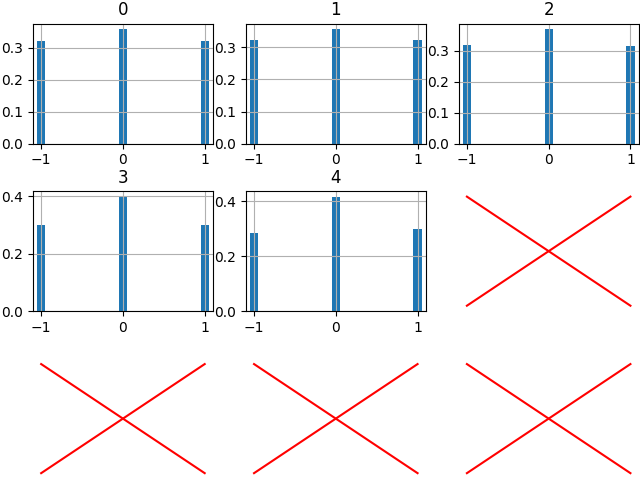

In [355]:
FIG_NAME = "dist"
plt.close(FIG_NAME)

num_plots = len(ds)
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1
width=0.1
for i, (ax, d) in enumerate(zip(axs, ds + [None]*len(axs))):
    if d is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(0, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(0, 1), '-', color="red")
        ax.axis("off")

    else:
        ax.set_title(i)
        vals = [pair.value for pair in d]
        probs = [pair.probability for pair in d]

        if len(vals) > 3:
            ax.plot(vals, probs, 'o-')
        else:
            ax.bar(vals, probs, width=width)

        min_x = min(min_x, min(vals))
        max_x = max(max_x, max(vals))

for ax in axs:
    ax.set_xlim(min_x-width, max_x+width)
    ax.grid()

fig.tight_layout(pad=0.1)
plt.show()

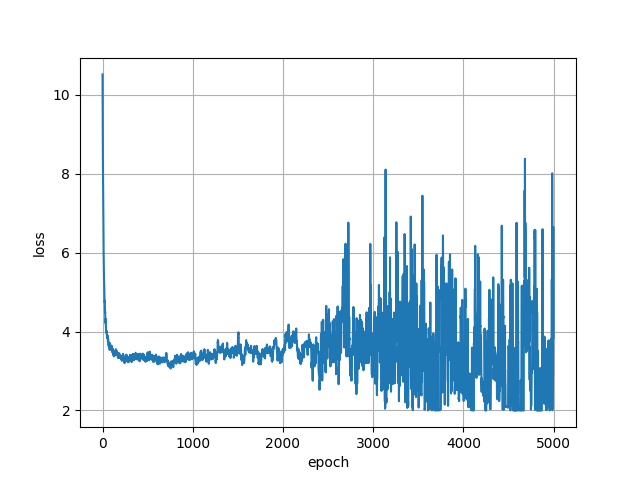

In [356]:
NAME = 'loss_curve_partial'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses[:train_epochs])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

In [357]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[ 0, -1,  0,  ..., -1, -1, -1],
        [-1,  0,  0,  ...,  0, -1,  0],
        [ 1,  1, -1,  ..., -1, -1, -1],
        ...,
        [ 0,  1, -1,  ...,  1, -1, -1],
        [-1,  1,  1,  ...,  1,  1, -1],
        [ 1,  1,  0,  ...,  0, -1, -1]], device='cuda:0', dtype=torch.int32) 
 tensor([[  -12,  1289,  1026,  ...,   220,  -580, -1261],
        [  -12,  1289,  1026,  ...,   220,  -580, -1261],
        [  -12,  1289,  1026,  ...,   220,  -580, -1261],
        ...,
        [  -12,  1289,  1026,  ...,   220,  -580, -1261],
        [  -12,  1289,  1026,  ...,   220,  -580, -1261],
        [  -12,  1289,  1026,  ...,   220,  -580, -1261]], device='cuda:0',
       dtype=torch.int32)
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[-1,  1,  0,  ...,  1,  0,  1],
        [ 1,  1,  0,  ...,  1,  1,  0],
        [ 0,  1, -1,  ...,  1, -1,  0],
        ...,
        [ 1, -1, -1,  ...,  1,  1, -1],
        [-1, -1,  1,  ...,  0, -1,  

In [358]:
assert bnn.network.network_params_al_ternary(TBNN)